# Milestone 2 - First Model

In [1]:
# imports 
import os 
import numpy as np
import matplotlib.pyplot as plt
from scripts import *
from first_scripts import *
from tqdm import tqdm
import pickle as pkl
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import pairwise_distances_argmin

### I. Data Prepration

In [2]:
# Read the data
# data_path = './data'
data_path = './DLCV_SS25_Dataset'  
images, labels = data_reader(data_path)


In [3]:
num_classes = len(os.listdir(data_path))
num_classes

5

In [4]:
len(images)

2351

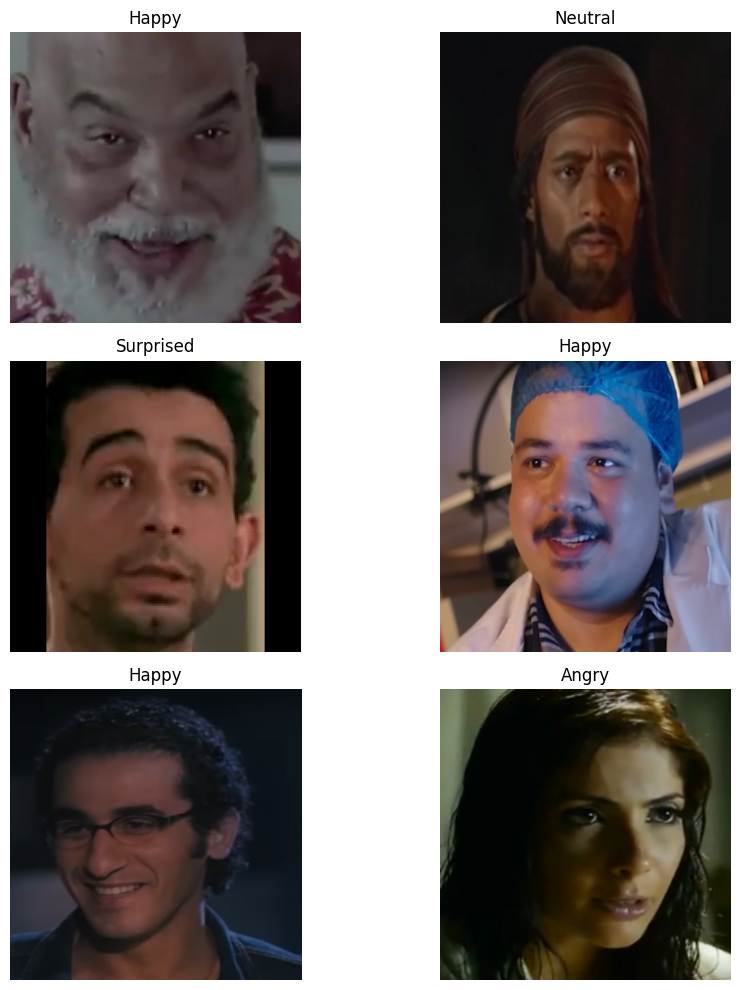

In [5]:
# View 4 random images and their titles
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(images))
    img = read_img(images[idx])
    ax.imshow(img)
    ax.set_title(labels[idx])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Preprocess the images 
train_tuple, val_tuple, test_tuple, label_to_index = data_preperator((images, labels))
index_to_label = {v: k for k, v in label_to_index.items()}

train_data, train_labels = train_tuple
val_data, val_labels = val_tuple
test_data, test_labels = test_tuple

train_data.shape, train_labels.shape, val_data.shape, val_labels.shape, test_data.shape, test_labels.shape

((1645,), (1645,), (470,), (470,), (236,), (236,))

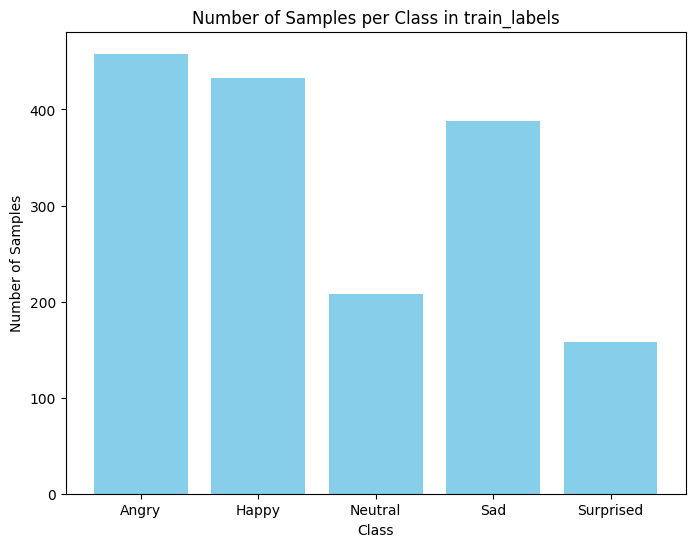

In [8]:
draw_barchart_labels(train_labels, label_to_index)

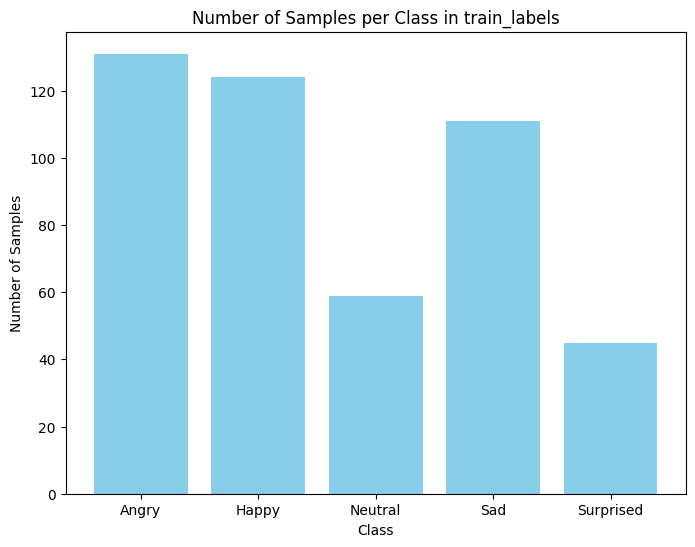

In [9]:
draw_barchart_labels(val_labels, label_to_index)

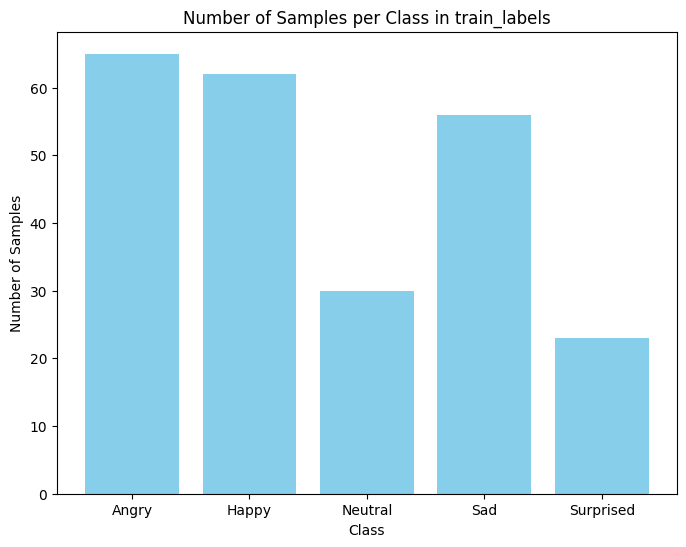

In [10]:
draw_barchart_labels(test_labels, label_to_index)

### II.First Model

In [10]:
# Predefined filters
import numpy as np

base_a = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

base_b = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])

base_c = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

base_d = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

base_e = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
])

filter_a = np.stack([base_a]*3, axis=-1)
filter_b = np.stack([base_b]*3, axis=-1)
filter_c = np.stack([base_c]*3, axis=-1)
filter_d = np.stack([base_d]*3, axis=-1)
filter_e = np.stack([base_e]*3, axis=-1)


filters = [filter_a, filter_b, filter_c, filter_d, filter_e]

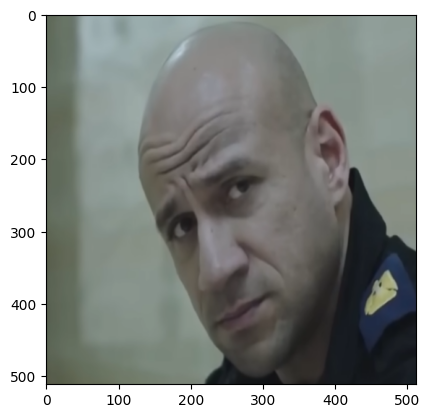

In [11]:
# Get example
path = train_data[0]
img = read_img(path)
# View img
plt.imshow(img) 

In [12]:
# Testing ConvLayer with Random filters
conv_layer = ConvLayer(4, (3, 3, 3))

output = conv_layer.forward(img)
output.shape

(510, 510, 4)

In [13]:
random_arr = np.random.rand(3, 3, 3)
random_arr_2 = np.random.rand(3, 3, 3)
np.dot(random_arr.flatten(), random_arr_2.flatten())

8.21974642075923

In [14]:
# Visualize the output of the convolutional layer
conv_layer = ConvLayer(5, (3, 3, 3), filter_weights=filters, fast_convolution=False)

output = conv_layer.forward(img)
output.shape

(510, 510, 5)

In [15]:
# Check if fast conv and normal conv are the same
conv_layer_fast = ConvLayer(5, (3, 3, 3), filter_weights=filters, fast_convolution=True)
output_fast = conv_layer_fast.forward(img)
conv_layer_normal = ConvLayer(5, (3, 3, 3), filter_weights=filters, fast_convolution=False)
output_normal = conv_layer_normal.forward(img)
print(f"Are the outputs the same? {np.equal(output_fast, output_normal).all()}")

Are the outputs the same? True


In [16]:
# Testing the pooling layer
pooling_layer = PoolingLayer(pooling_type='MAX', pool_size=(2, 2))

output = pooling_layer.forward(img)
output.shape

(256, 256, 3)

#### Use Predefined Filters

In [36]:
# Trying to apply the first model on the image
first_model = FirstModel()
print("finish loading data...")
example_data = np.array(img)
output = first_model.forward(example_data)
output.shape

finish loading data...


(1, 128)

In [37]:

# Running the model on all of the data
at_once = 20
output = []
for i in tqdm(range(0, len(train_data), at_once), desc="Processing images"):
    # Load at_once images
    batch_end = min(at_once, len(train_data) - i)
    data = [read_img(train_data[i + j]) for j in range(batch_end)]
    
    for j in range(len(data)):
        input_img = np.array(data[j])
        output.append(first_model.forward(input_img))

# Convert to numpy array
output = np.array(output)
output.shape

Processing images: 100%|██████████| 83/83 [08:22<00:00,  6.06s/it]


(1645, 1, 128)

In [38]:
# Fixing the output shape by removing the middle dimension
if len(output.shape) == 3:
    output = np.squeeze(output, axis=1)
output.shape

(1645, 128)

In [86]:
features_path = './features/first_model_features_predefined_weights.pkl'

In [ ]:
with open(features_path, 'wb') as f:
    pkl.dump(output, f)

In [87]:
with open(features_path, 'rb') as f:
    output = pkl.load(f)

#### Fit Sklearn KMeans on trained model

In [88]:
# Fit kmeans 
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(output)


kmeans = KMeans(n_clusters=5, random_state=0, init='k-means++', max_iter=1000)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_
# Get the silhouette score
silhouette_avg = silhouette_score(X_scaled, labels)

print(f'Shape of labels: {labels.shape}')
print(f'Shape of cluster centers: {cluster_centers.shape}')
print(f'Number of clusters: {len(cluster_centers)}')
print(f'Silhouette score: {silhouette_avg}')

Shape of labels: (1645,)
Shape of cluster centers: (5, 128)
Number of clusters: 5
Silhouette score: 0.0840567343085754


c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The silhouette score is +ve but very small which indicates that the clusters are barely distinct, with many points likely close to the boundaries of multiple clusters or misassigned. The clustering may not be meaningful or effective.

In [89]:
# count number of labels in each cluster
unique, counts = np.unique(labels, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4]), array([297, 294, 228, 327, 499], dtype=int64))

In [90]:
from collections import Counter
def map_clusters_to_labels(cluster_ids: np.ndarray, true_labels: np.ndarray) -> Tuple[np.ndarray, Dict[int, int]]:
    """
    Maps cluster IDs to true labels based on the most common true label in each cluster.

    Args:
        cluster_ids (np.ndarray): Array of cluster IDs assigned by KMeans.
        true_labels (np.ndarray): Array of true labels corresponding to the data points.
    
    Returns:
        Tuple[np.ndarray, Dict[int, int]]: A tuple containing:
            - An array of mapped labels for each cluster ID.
            - A dictionary mapping each cluster ID to its most common true label.
    """
    mapped_labels = np.zeros_like(cluster_ids)
    clusters_to_labels = {}
    labels_set = set()
    for cl in np.unique(cluster_ids):
        mask = (cluster_ids == cl)
        mode_labels = Counter(true_labels[mask]).most_common()
        chosen_label = None
        print(f"Cluster {cl}: True labels {mode_labels}")
        for label, _ in mode_labels:
            if label not in labels_set:
                chosen_label = label
                break
        mapped_labels[mask] = chosen_label
        print(f"Cluster {cl}: True label {mapped_labels[mask][0]}")
        clusters_to_labels[cl] = mapped_labels[mask][0]
        labels_set.add(mapped_labels[mask][0])
    return mapped_labels, clusters_to_labels
    
y_pred, cluster_to_labels = map_clusters_to_labels(labels, train_labels)




Cluster 0: True labels [(1, 89), (0, 83), (3, 77), (2, 25), (4, 23)]
Cluster 0: True label 1
Cluster 1: True labels [(0, 88), (1, 77), (3, 61), (2, 36), (4, 32)]
Cluster 1: True label 0
Cluster 2: True labels [(1, 89), (0, 65), (2, 32), (3, 27), (4, 15)]
Cluster 2: True label 2
Cluster 3: True labels [(0, 105), (3, 74), (1, 72), (2, 48), (4, 28)]
Cluster 3: True label 3
Cluster 4: True labels [(3, 149), (0, 117), (1, 106), (2, 67), (4, 60)]
Cluster 4: True label 4


In [91]:
def plot_cm(cm: np.ndarray):
    """
    Plot the confusion matrix using matplotlib.
    Args:
        cm (np.ndarray): Confusion matrix to plot.
    """
    plt.figure()
    plt.imshow(cm)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.colorbar()
    # Annotate each cell with the count
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha='center', va='center')

Clustering accuracy for training: 20.85%


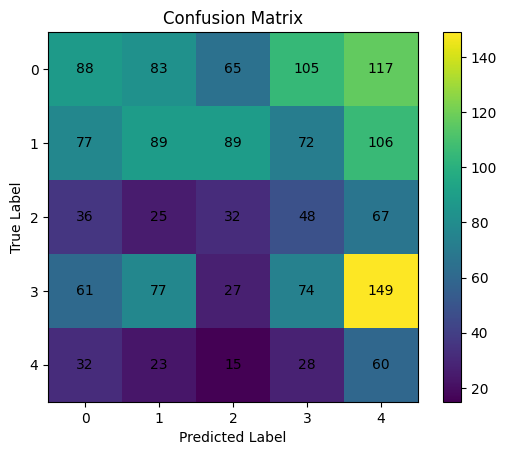

In [92]:
acc = accuracy_score(train_labels, y_pred)
print(f"Clustering accuracy for training: {acc:.2%}")
cm  = confusion_matrix(train_labels, y_pred)
plot_cm(cm)

- **Cluster 3 dominates**: It has the highest count for every true class, acting like a “catch-all” cluster.  
- **Heavy mixing**: Large off-diagonal values show that no cluster cleanly corresponds to a single class.  
- **Classes 2 & 4 classified badly**: Almost all their samples land in cluster 3, with very few in any other cluster (as they are a minority in the dataset).

##### Use Mean of features as predefined centroids

In [93]:
import numpy as np
from sklearn.cluster import KMeans

# X: (n_samples, n_features); y: true labels {0,…,4}
X = output
y = train_labels
classes = np.unique(y)  

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


init_centroids = np.array([X_scaled[y == cls].mean(axis=0) for cls in classes])
print(f"Centroids shape: {init_centroids.shape}")


kmeans = KMeans(
    n_clusters=len(classes),
    init=init_centroids,
    n_init=1,            
    max_iter=1,
    random_state=42
)
kmeans.fit(X_scaled)

c_seeded = kmeans.labels_


Centroids shape: (5, 128)


In [94]:
cluster_centers = kmeans.cluster_centers_

# calculate distances between init centroids and the cluster centers
distances = np.linalg.norm(init_centroids - cluster_centers, axis=1)
print(f"Distances between init centroids and cluster centers: {distances}")

Distances between init centroids and cluster centers: [0.49633521 0.60254289 0.45745067 0.59247107 0.49388767]


Silhouette score: 0.044314443168021696
Clustering accuracy for training: 27.42%


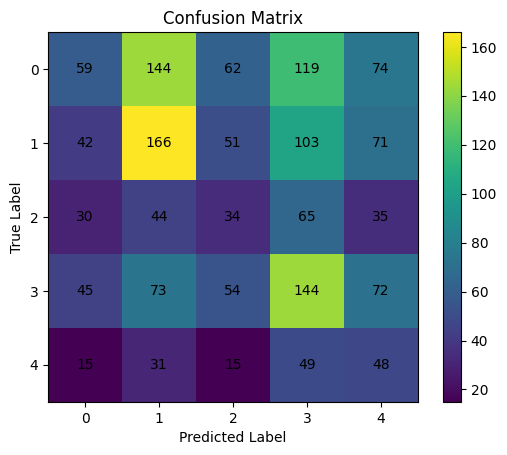

In [95]:
# After one iteration of Kmeans, the cluster centers are updated.
silhouette_avg = silhouette_score(output, c_seeded)
print(f'Silhouette score: {silhouette_avg}')
acc = accuracy_score(train_labels, c_seeded)
print(f"Clustering accuracy for training: {acc:.2%}")
cm  = confusion_matrix(train_labels, c_seeded)
plot_cm(cm)

- **Clusters 1 & 3 act as “catch-alls”**: classes 0 & 1 land mostly in cluster 1 (144 & 166), while classes 2, 3 & 4 go mainly into cluster 3 (65, 144 & 49).  
- **Heavy mixing everywhere**: sizeable off-diagonal counts show samples from every class scatter across multiple clusters.  
- **No pure clusters**: even the dominant clusters contain substantial numbers of other classes, so none cleanly isolates a single true label.

#### Use Kmeans from Scratch

##### Train Kmeans for some iters

In [96]:
# Fit kmeans 
X = output
y = train_labels
classes = np.unique(y)  

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeansScratch(n_clusters=5, max_iter=1000)
kmeans.fit(X_scaled)
labels = kmeans.predict(X_scaled)

# Get the cluster centers
cluster_centers = kmeans.centroids
# Get the silhouette score
silhouette_avg = silhouette_score(X_scaled, labels)

print(f'Shape of labels: {labels.shape}')
print(f'Shape of cluster centers: {cluster_centers.shape}')
print(f'Number of clusters: {len(cluster_centers)}')
print(f'Silhouette score: {silhouette_avg}')

Shape of labels: (1645,)
Shape of cluster centers: (5, 128)
Number of clusters: 5
Silhouette score: 0.08542744343771105


Cluster 0.0: True labels [(0, 83), (3, 75), (1, 74), (2, 24), (4, 22)]
Cluster 0.0: True label 0.0
Cluster 1.0: True labels [(0, 90), (1, 87), (3, 67), (2, 32), (4, 29)]
Cluster 1.0: True label 1.0
Cluster 2.0: True labels [(3, 150), (0, 120), (1, 109), (2, 72), (4, 64)]
Cluster 2.0: True label 3.0
Cluster 3.0: True labels [(0, 103), (1, 74), (3, 67), (2, 52), (4, 27)]
Cluster 3.0: True label 2.0
Cluster 4.0: True labels [(1, 89), (0, 62), (3, 29), (2, 28), (4, 16)]
Cluster 4.0: True label 4.0
Clustering accuracy for training: 23.59%


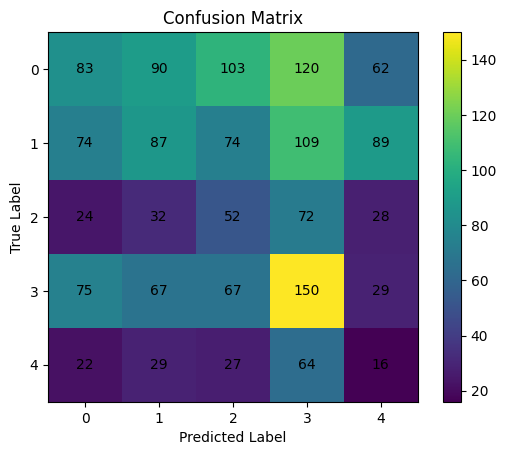

In [97]:
y_pred, cluster_to_labels = map_clusters_to_labels(labels, train_labels)
acc = accuracy_score(train_labels, y_pred)
print(f"Clustering accuracy for training: {acc:.2%}")
cm  = confusion_matrix(train_labels, y_pred)
plot_cm(cm)

- **Cluster 3 is the “catch-all”**: it has the highest count for every class (0: 120, 1: 109, 2: 72, 3: 150, 4: 64).  
- **Strong secondary pull for classes 0 & 2 into cluster 2**: they’re next-largest there (103 & 52), unlike other classes.  
- **Widespread mixing**: substantial off-diagonals show no cluster cleanly isolates a single true label.

##### Use Mean of features as predefined centroids

In [98]:
# X: (n_samples, n_features); y: true labels {0,…,4}
X = output
y = train_labels
classes = np.unique(y)  

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


init_centroids = np.array([X_scaled[y == cls].mean(axis=0) for cls in classes])
print(f"Centroids shape: {init_centroids.shape}")


kmeans = KMeansScratch(
    n_clusters=len(classes),
    init_centroids=init_centroids,
    max_iter=0,
)
kmeans.fit(X_scaled)
labels = kmeans.predict(X_scaled)


Centroids shape: (5, 128)


In [99]:
cluster_centers = kmeans.centroids

# calculate distances between init centroids and the cluster centers
distances = np.linalg.norm(init_centroids - cluster_centers, axis=1)
print(f"Distances between init centroids and cluster centers: {distances}")

Distances between init centroids and cluster centers: [0. 0. 0. 0. 0.]


Silhouette score: 0.030080982279966795
Clustering accuracy for training: 29.85%


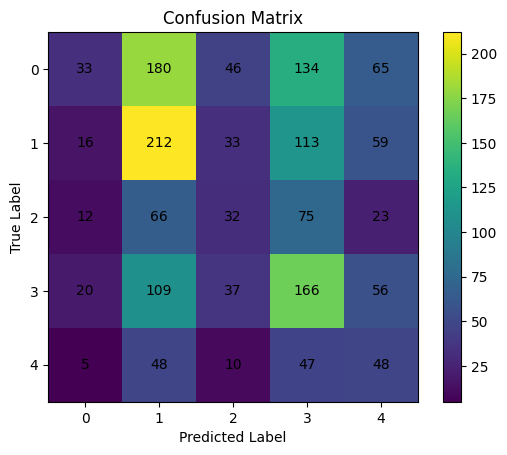

In [100]:
silhouette_avg = silhouette_score(X_scaled, labels)
print(f'Silhouette score: {silhouette_avg}')
acc = accuracy_score(train_labels, labels)
print(f"Clustering accuracy for training: {acc:.2%}")
cm  = confusion_matrix(train_labels, labels)
plot_cm(cm)

- **Cluster 1 vs. Cluster 3 split**: Cluster 1 captures most of classes 0 & 1 (180 & 212), while Cluster 3 leads for classes 2 & 3 (75 & 166).  
- **Class 4 evenly divided**: Its samples are almost equally split between clusters 1 (48), 3 (47) and 4 (48), so no clear home.  
- **Persistent mixing**: Large off-diagonal counts show none of the clusters cleanly isolate a single class.

#### Plot Features

In [101]:
# Method to apply pca then kmeans to be able to visualize the data
def plot_feature_scatter(
    features: np.ndarray,
    clusters:int=5,
    n_components: int = 2,
    predetermined_centorids: np.ndarray = None,
):
    """
    Plot PCA-reduced features in 2D or 3D based on n_components.

    Args:
        features (np.ndarray): Feature matrix of shape (N, D).
        clusters (int): Number of clusters for KMeans.
        n_components (int): 2 for 2D plot, 3 for 3D plot.
        predetermined_centorids (np.ndarray): Optional, if provided, KMeans will use these as initial centroids.
    """
    proj = PCA(n_components=n_components).fit_transform(features)

    # Normalize the data
    scaler = MinMaxScaler()
    proj = scaler.fit_transform(proj)    

    # Fit KMeans on the PCA-reduced data
    if predetermined_centorids is not None:
        kmeans = KMeans(n_clusters=clusters, init=predetermined_centorids, n_init=1, max_iter=1)
    else:    
        kmeans = KMeans(n_clusters=clusters, random_state=0, init='k-means++', max_iter=1000)
    kmeans.fit(proj)
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_


    figsize = (20,20)

    fig = plt.figure(figsize=figsize)

    if n_components == 2:
        ax = fig.add_subplot(111)
        scatter = ax.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='tab10', s=20)
        handles, legend_labels = scatter.legend_elements()
        ax.legend(handles, legend_labels, title="Cluster")
        
        centers = ax.scatter(
            cluster_centers[:, 0], 
            cluster_centers[:, 1], 
            c='black', 
            s=200, 
            alpha=0.7, 
            marker='X',
            edgecolors='white',
            linewidths=2,
            label='Cluster Centers'
        )
        
        handles.append(centers)
        legend_labels = list(legend_labels) + ['Cluster Centers']
        ax.legend(handles, legend_labels, title="Cluster", loc='best')
        
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_title("2D PCA Projection of Cluster Assignments")

    elif n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], c=labels, cmap='tab10', s=20)
        handles, legend_labels = scatter.legend_elements()
        
        # Add cluster centers
        centers = ax.scatter(
            cluster_centers[:, 0], 
            cluster_centers[:, 1], 
            cluster_centers[:, 2], 
            c='black', 
            s=200, 
            alpha=0.7, 
            marker='X',
            edgecolors='white',
            linewidths=2,
            label='Cluster Centers'
        )
        
        handles.append(centers)
        legend_labels = list(legend_labels) + ['Cluster Centers']
        ax.legend(handles, legend_labels, title="Cluster", loc='best')
        
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("3D PCA Projection of Cluster Assignments")

    else:
        raise ValueError("n_components must be 2 or 3 for plotting")

    plt.show()

c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


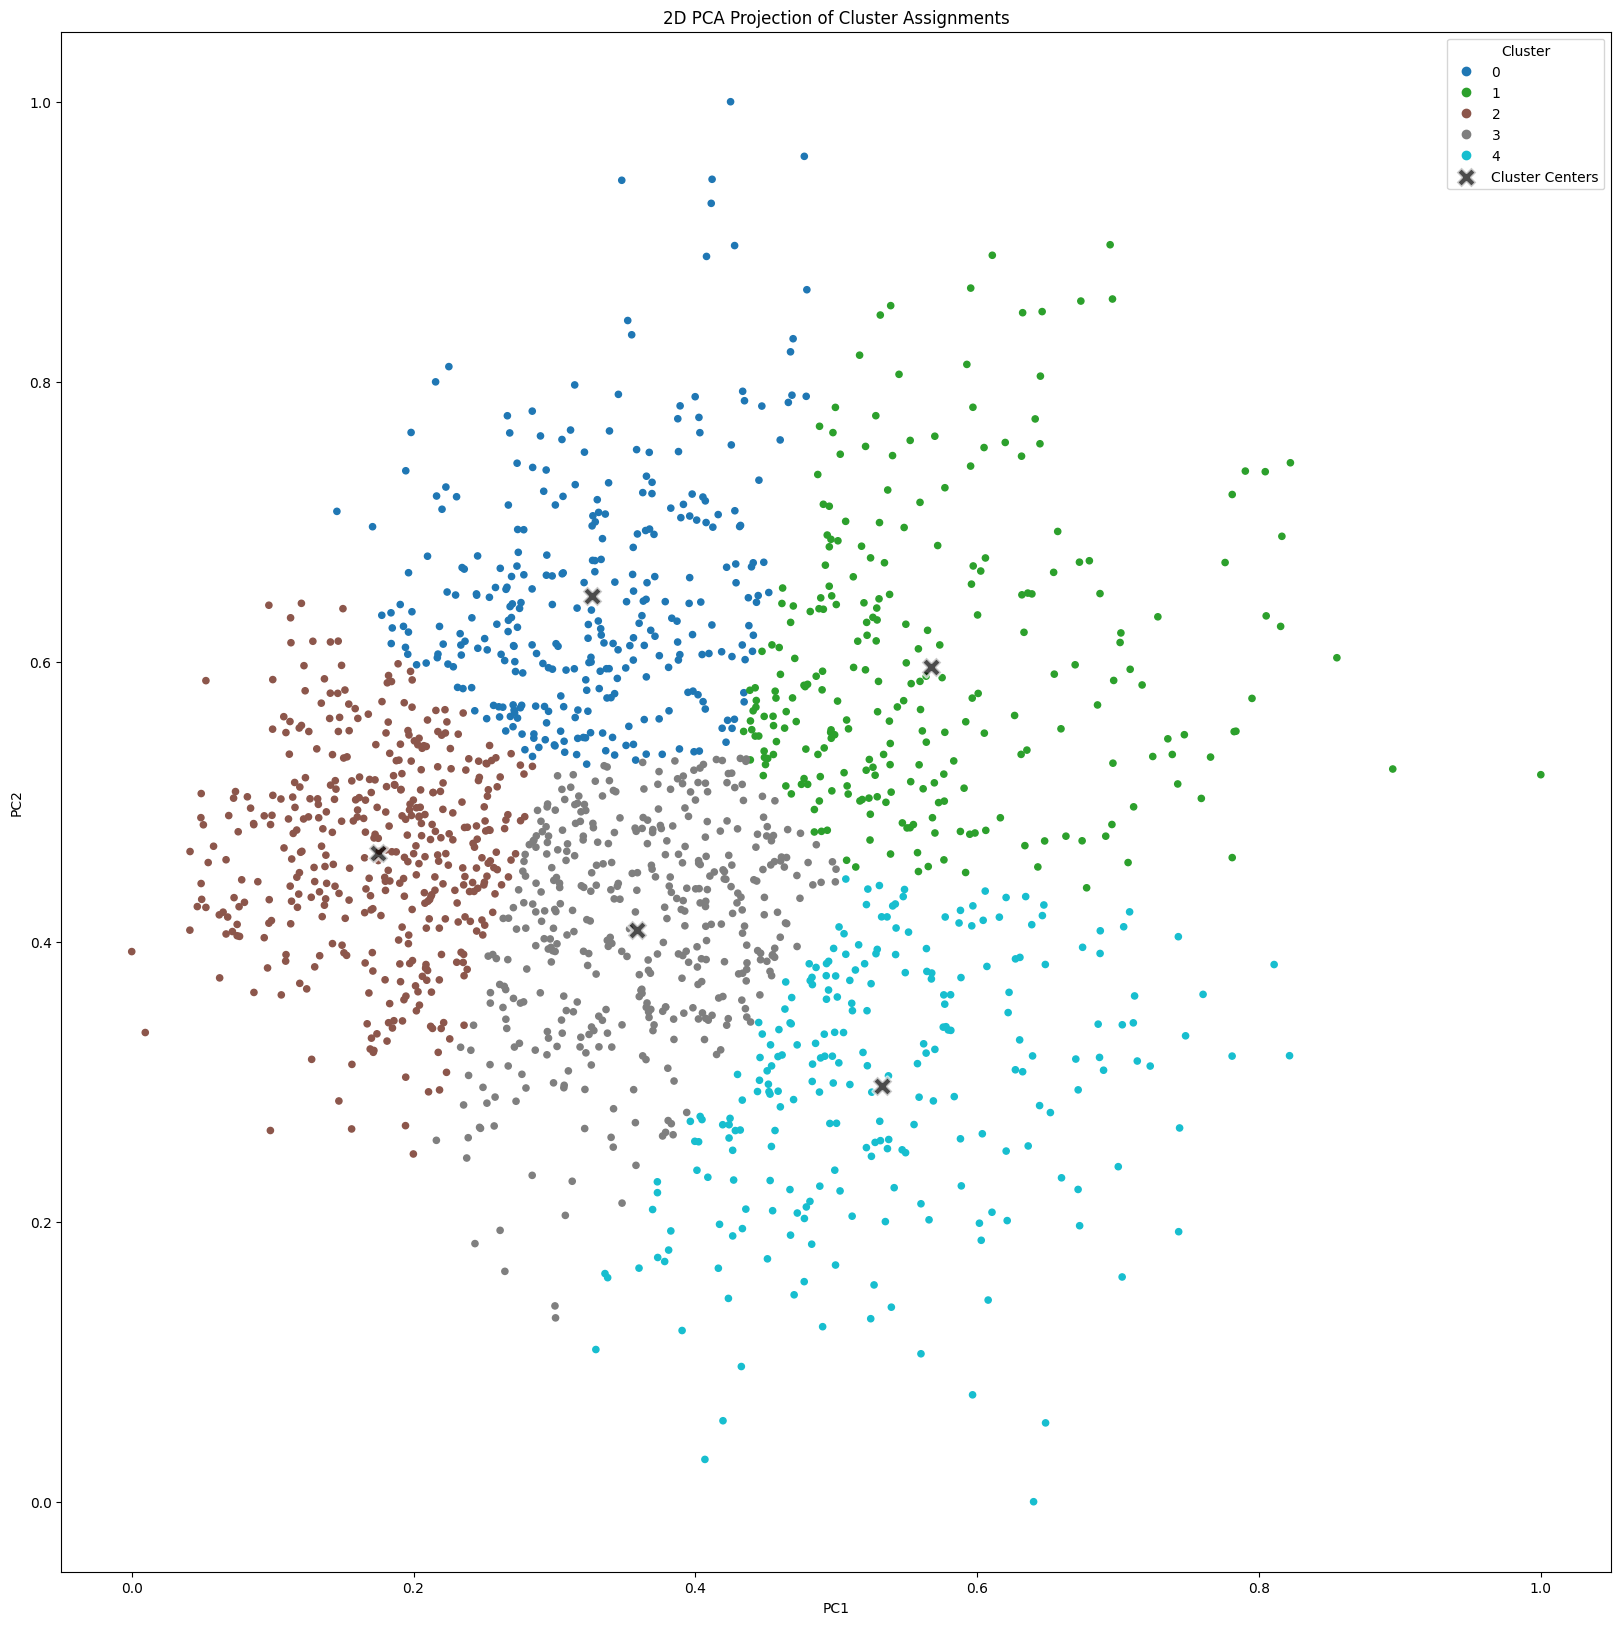

In [102]:
plot_feature_scatter(output, clusters=5, n_components=2)

c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


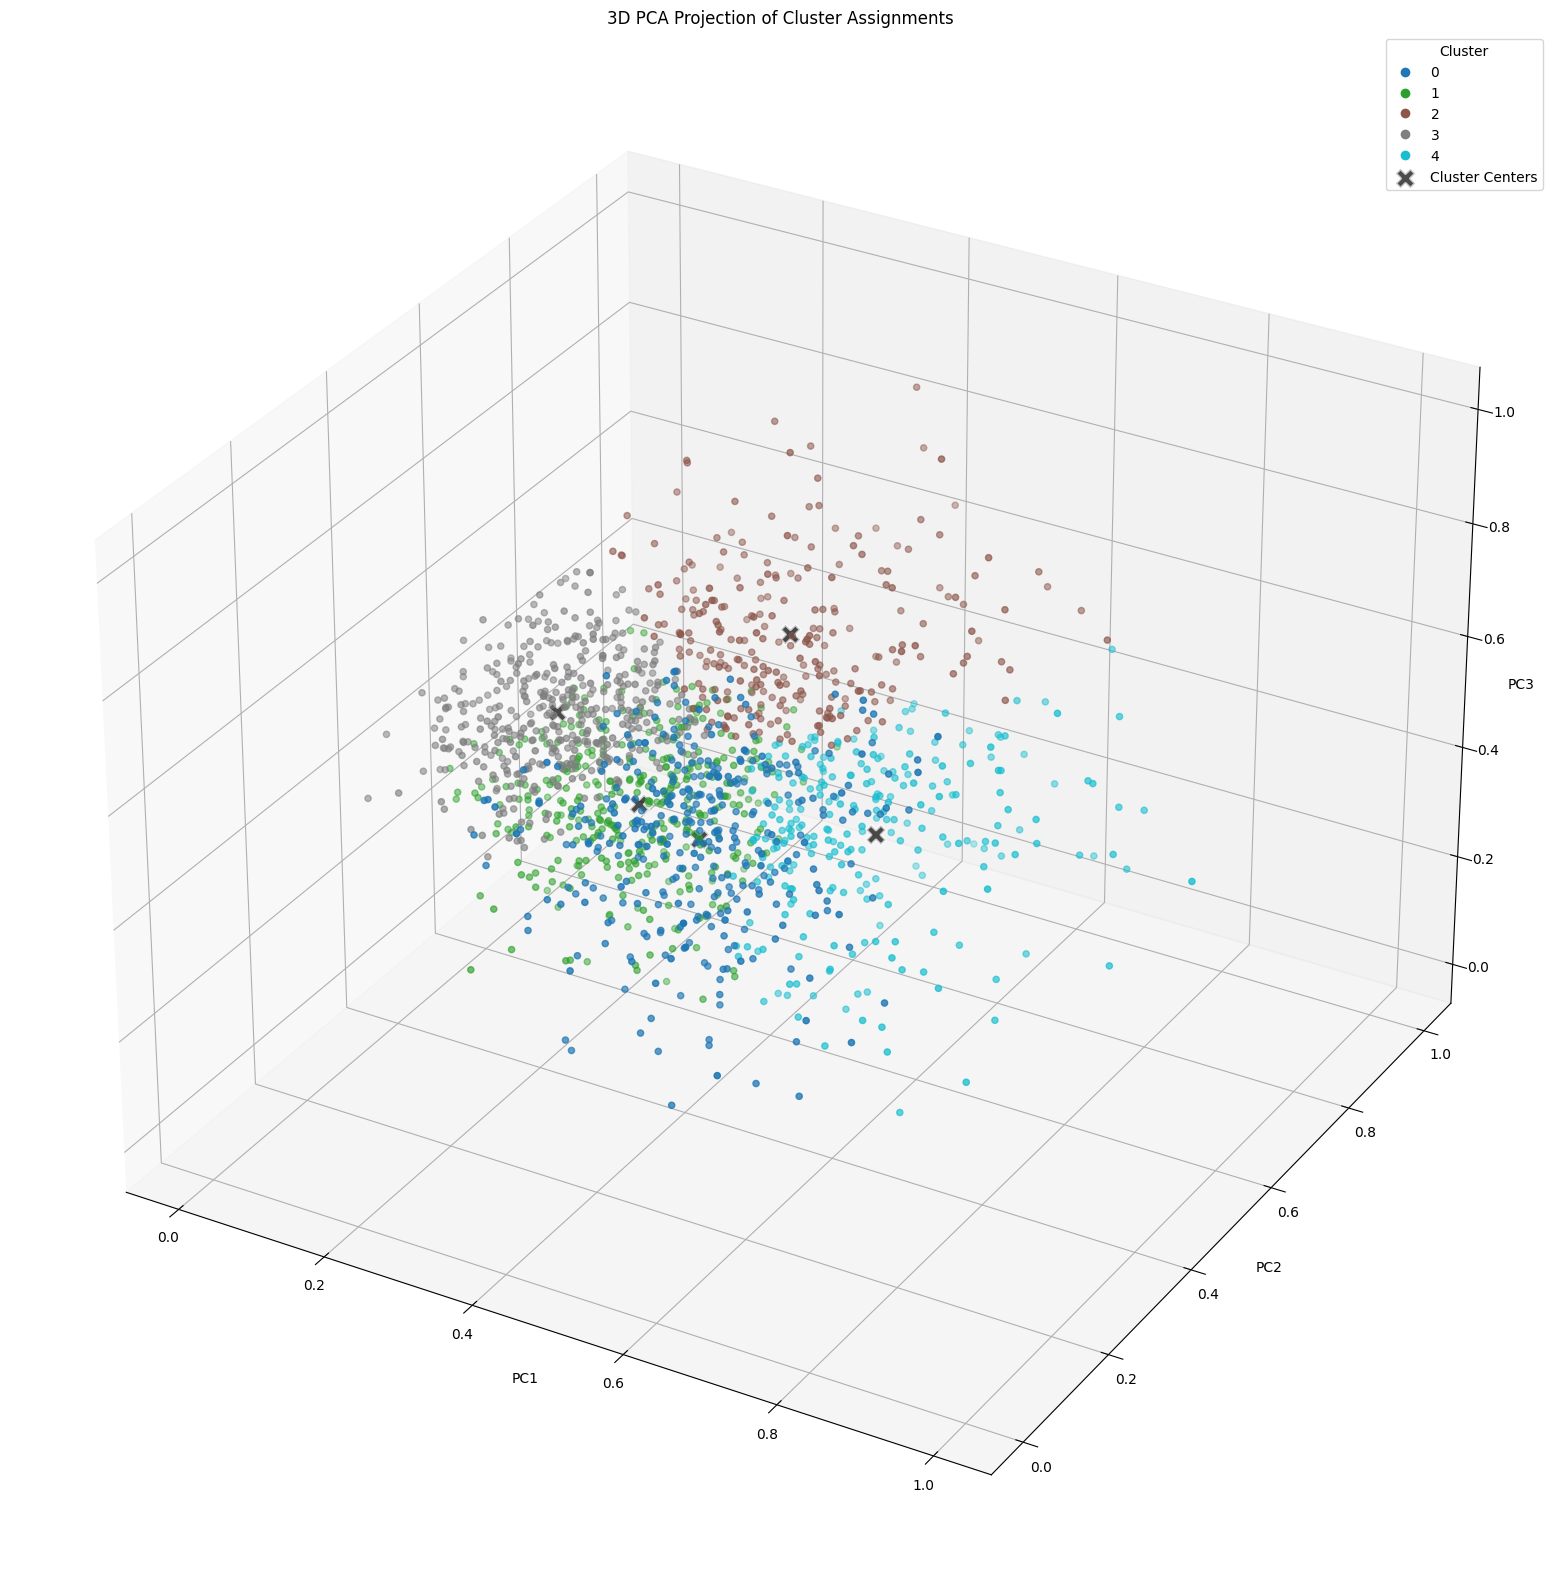

In [103]:
# Plot a 3D scatter plot
plot_feature_scatter(output, clusters=5, n_components=3)

#### Use Random Filters

In [73]:
# Trying to apply the first model on the image
first_model = FirstModel(use_predefined_filters=False)
print("finish loading data...")
example_data = np.array(img)
output = first_model.forward(example_data)
output.shape

finish loading data...


(1, 128)

In [74]:

# Running the model on all of the data
at_once = 20
output = []
for i in tqdm(range(0, len(train_data), at_once), desc="Processing images"):
    # Load at_once images
    batch_end = min(at_once, len(train_data) - i)
    data = [read_img(train_data[i + j]) for j in range(batch_end)]
    
    for j in range(len(data)):
        input_img = np.array(data[j])
        output.append(first_model.forward(input_img))

# Convert to numpy array
output = np.array(output)
output.shape

Processing images: 100%|██████████| 83/83 [08:15<00:00,  5.97s/it]


(1645, 1, 128)

In [75]:
# Fixing the output shape by removing the middle dimension
if len(output.shape) == 3:
    output = np.squeeze(output, axis=1)
output.shape

(1645, 128)

In [66]:
features_path = './features/first_model_features_random_weights.pkl'

In [ ]:
with open(features_path, 'wb') as f:
    pkl.dump(output, f)

In [67]:
with open(features_path, 'rb') as f:
    output = pkl.load(f)

In [68]:
# Fit kmeans 
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(output)

kmeans = KMeans(n_clusters=5, random_state=0, init='k-means++', max_iter=1000)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_
# Get the silhouette score
silhouette_avg = silhouette_score(output, labels)

print(f'Shape of labels: {labels.shape}')
print(f'Shape of cluster centers: {cluster_centers.shape}')
print(f'Number of clusters: {len(cluster_centers)}')
print(f'Silhouette score: {silhouette_avg}')

Shape of labels: (1645,)
Shape of cluster centers: (5, 128)
Number of clusters: 5
Silhouette score: 0.09552015331647788


c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The silhouette score is +ve but very small which indicates that the clusters are barely distinct, with many points likely close to the boundaries of multiple clusters or misassigned. The clustering may not be meaningful or effective.

In [69]:
# count number of labels in each cluster
unique, counts = np.unique(labels, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4]), array([324, 302, 354, 238, 427], dtype=int64))

In [70]:
y_pred, cluster_to_labels = map_clusters_to_labels(labels, train_labels)

Cluster 0: True labels [(1, 99), (0, 92), (3, 75), (2, 35), (4, 23)]
Cluster 0: True label 1
Cluster 1: True labels [(1, 82), (3, 80), (0, 68), (4, 43), (2, 29)]
Cluster 1: True label 3
Cluster 2: True labels [(0, 113), (3, 82), (1, 79), (2, 48), (4, 32)]
Cluster 2: True label 0
Cluster 3: True labels [(1, 92), (0, 69), (3, 30), (2, 29), (4, 18)]
Cluster 3: True label 2
Cluster 4: True labels [(3, 121), (0, 116), (1, 81), (2, 67), (4, 42)]
Cluster 4: True label 4


Clustering accuracy for training: 22.07%


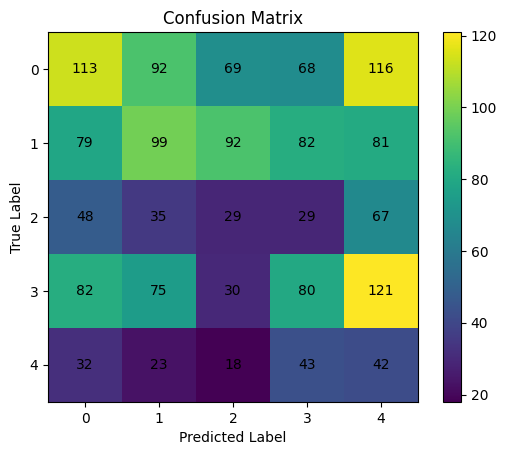

In [71]:
acc = accuracy_score(train_labels, y_pred)
print(f"Clustering accuracy for training: {acc:.2%}")
cm  = confusion_matrix(train_labels, y_pred)
plot_cm(cm)

##### Use Mean of features as predefined centroids

In [72]:
import numpy as np
from sklearn.cluster import KMeans

# X: (n_samples, n_features); y: true labels {0,…,4}
X = output
y = train_labels
classes = np.unique(y) 

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

init_centroids = np.array([X_scaled[y == cls].mean(axis=0) for cls in classes])
print(f"Centroids shape: {init_centroids.shape}")


kmeans = KMeans(
    n_clusters=len(classes),
    init=init_centroids,
    n_init=1,            
    max_iter=1,
    random_state=42
)
kmeans.fit(X_scaled)

c_seeded = kmeans.labels_


Centroids shape: (5, 128)


In [73]:
cluster_centers = kmeans.cluster_centers_

# distance between the cluster centers and the init_centroids
distances = np.linalg.norm(cluster_centers - init_centroids, axis=1)
print(f"Distances between cluster centers and init centroids: {distances}")

Distances between cluster centers and init centroids: [0.38960841 0.52798041 0.447133   0.55342209 0.43754447]


Silhouette score: 0.07309994906833407
Clustering accuracy for training: 26.63%


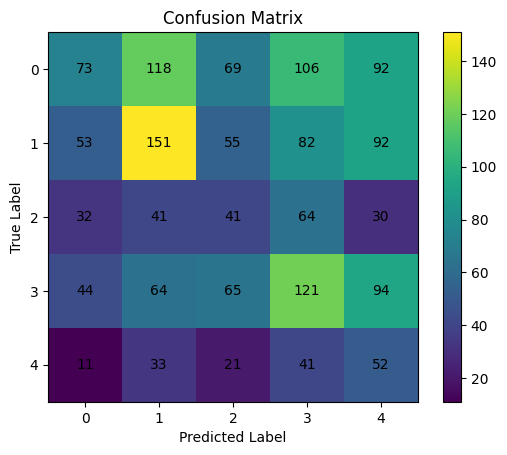

In [74]:
silhouette_avg = silhouette_score(output, c_seeded)
print(f'Silhouette score: {silhouette_avg}')
acc = accuracy_score(train_labels, c_seeded)
print(f"Clustering accuracy for training: {acc:.2%}")
cm  = confusion_matrix(train_labels, c_seeded)
plot_cm(cm)

In [75]:
labels_fixed = pairwise_distances_argmin(X_scaled, init_centroids)

Silhouette score: 0.037992748268070586
Clustering accuracy for training: 27.96%


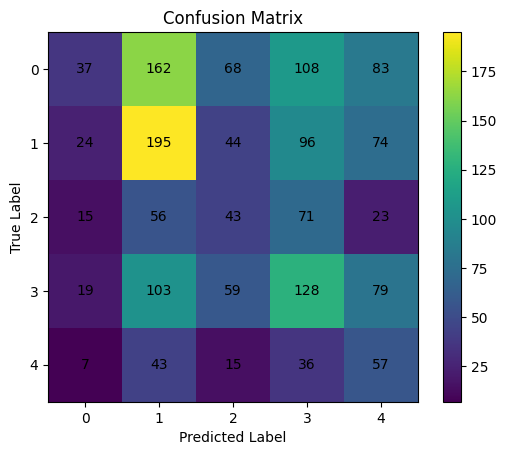

In [76]:
silhouette_avg = silhouette_score(X_scaled, labels_fixed)
print(f'Silhouette score: {silhouette_avg}')
acc = accuracy_score(train_labels, labels_fixed)
print(f"Clustering accuracy for training: {acc:.2%}")
cm  = confusion_matrix(train_labels, labels_fixed)
plot_cm(cm)

##### Use Kmeans from Scratch

##### Train Kmeans for some iters

In [77]:
# Fit kmeans 
X = output
y = train_labels
classes = np.unique(y)  

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeansScratch(n_clusters=5, max_iter=1000)
kmeans.fit(X_scaled)
labels = kmeans.predict(X_scaled)

# Get the cluster centers
cluster_centers = kmeans.centroids
# Get the silhouette score
silhouette_avg = silhouette_score(X_scaled, labels)

print(f'Shape of labels: {labels.shape}')
print(f'Shape of cluster centers: {cluster_centers.shape}')
print(f'Number of clusters: {len(cluster_centers)}')
print(f'Silhouette score: {silhouette_avg}')

Shape of labels: (1645,)
Shape of cluster centers: (5, 128)
Number of clusters: 5
Silhouette score: 0.08450450273923535


Cluster 0.0: True labels [(0, 98), (1, 78), (3, 69), (2, 41), (4, 28)]
Cluster 0.0: True label 0.0
Cluster 1.0: True labels [(1, 97), (3, 89), (0, 76), (4, 38), (2, 26)]
Cluster 1.0: True label 1.0
Cluster 2.0: True labels [(3, 113), (0, 106), (1, 78), (2, 63), (4, 45)]
Cluster 2.0: True label 3.0
Cluster 3.0: True labels [(0, 99), (1, 88), (3, 80), (2, 52), (4, 30)]
Cluster 3.0: True label 2.0
Cluster 4.0: True labels [(1, 92), (0, 79), (3, 37), (2, 26), (4, 17)]
Cluster 4.0: True label 4.0
Clustering accuracy for training: 22.92%


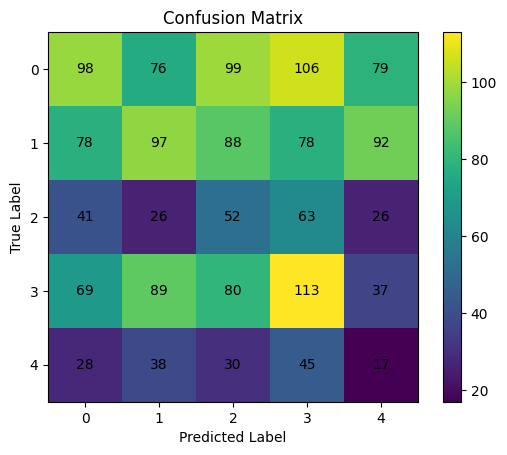

In [78]:
y_pred, cluster_to_labels = map_clusters_to_labels(labels, train_labels)
acc = accuracy_score(train_labels, y_pred)
print(f"Clustering accuracy for training: {acc:.2%}")
cm  = confusion_matrix(train_labels, y_pred)
plot_cm(cm)

##### Use Mean of features as predefined centroids

In [79]:
# X: (n_samples, n_features); y: true labels {0,…,4}
X = output
y = train_labels
classes = np.unique(y)  

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


init_centroids = np.array([X_scaled[y == cls].mean(axis=0) for cls in classes])
print(f"Centroids shape: {init_centroids.shape}")


kmeans = KMeansScratch(
    n_clusters=len(classes),
    init_centroids=init_centroids,
    max_iter=0,
)
kmeans.fit(X_scaled)
labels = kmeans.predict(X_scaled)


Centroids shape: (5, 128)


In [80]:
cluster_centers = kmeans.centroids

# calculate distances between init centroids and the cluster centers
distances = np.linalg.norm(init_centroids - cluster_centers, axis=1)
print(f"Distances between init centroids and cluster centers: {distances}")

Distances between init centroids and cluster centers: [0. 0. 0. 0. 0.]


Silhouette score: 0.037992748268070586
Clustering accuracy for training: 27.96%


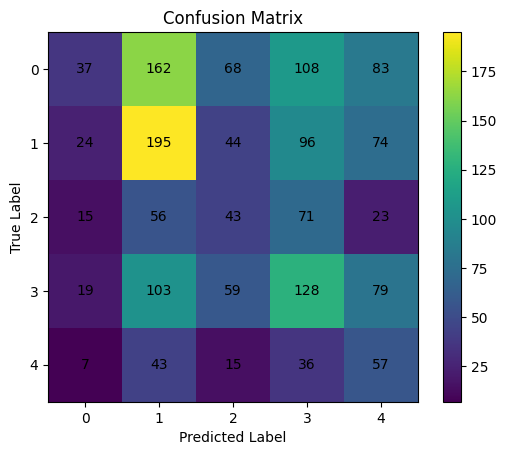

In [81]:
# After one iteration of Kmeans, the cluster centers are updated.
silhouette_avg = silhouette_score(X_scaled, labels)
print(f'Silhouette score: {silhouette_avg}')
acc = accuracy_score(train_labels, labels)
print(f"Clustering accuracy for training: {acc:.2%}")
cm  = confusion_matrix(train_labels, labels)
plot_cm(cm)

##### Plot Features

c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


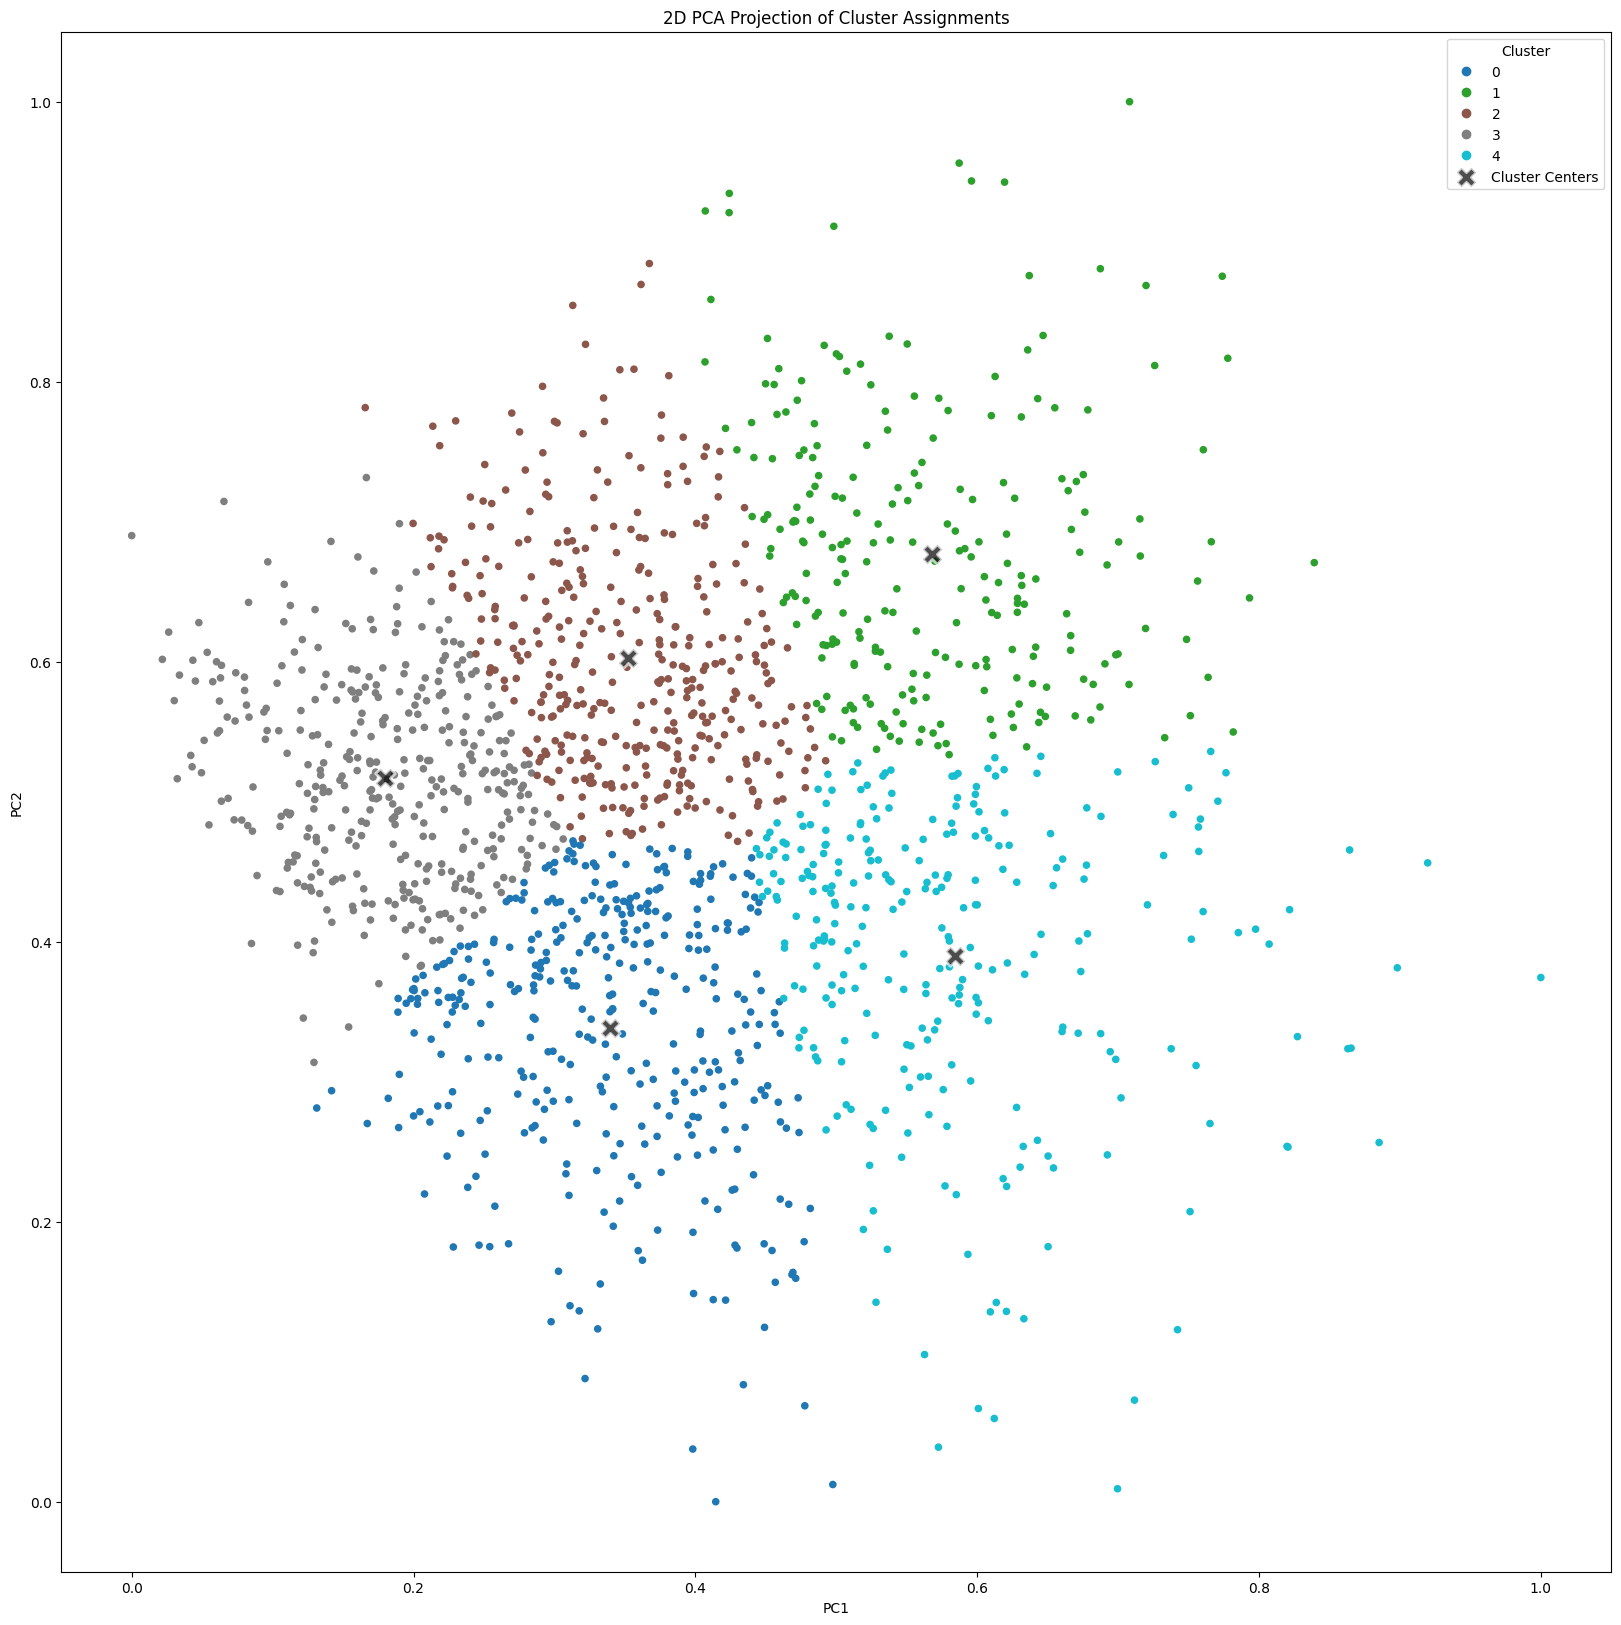

In [84]:
plot_feature_scatter(output, clusters=5, n_components=2)

c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


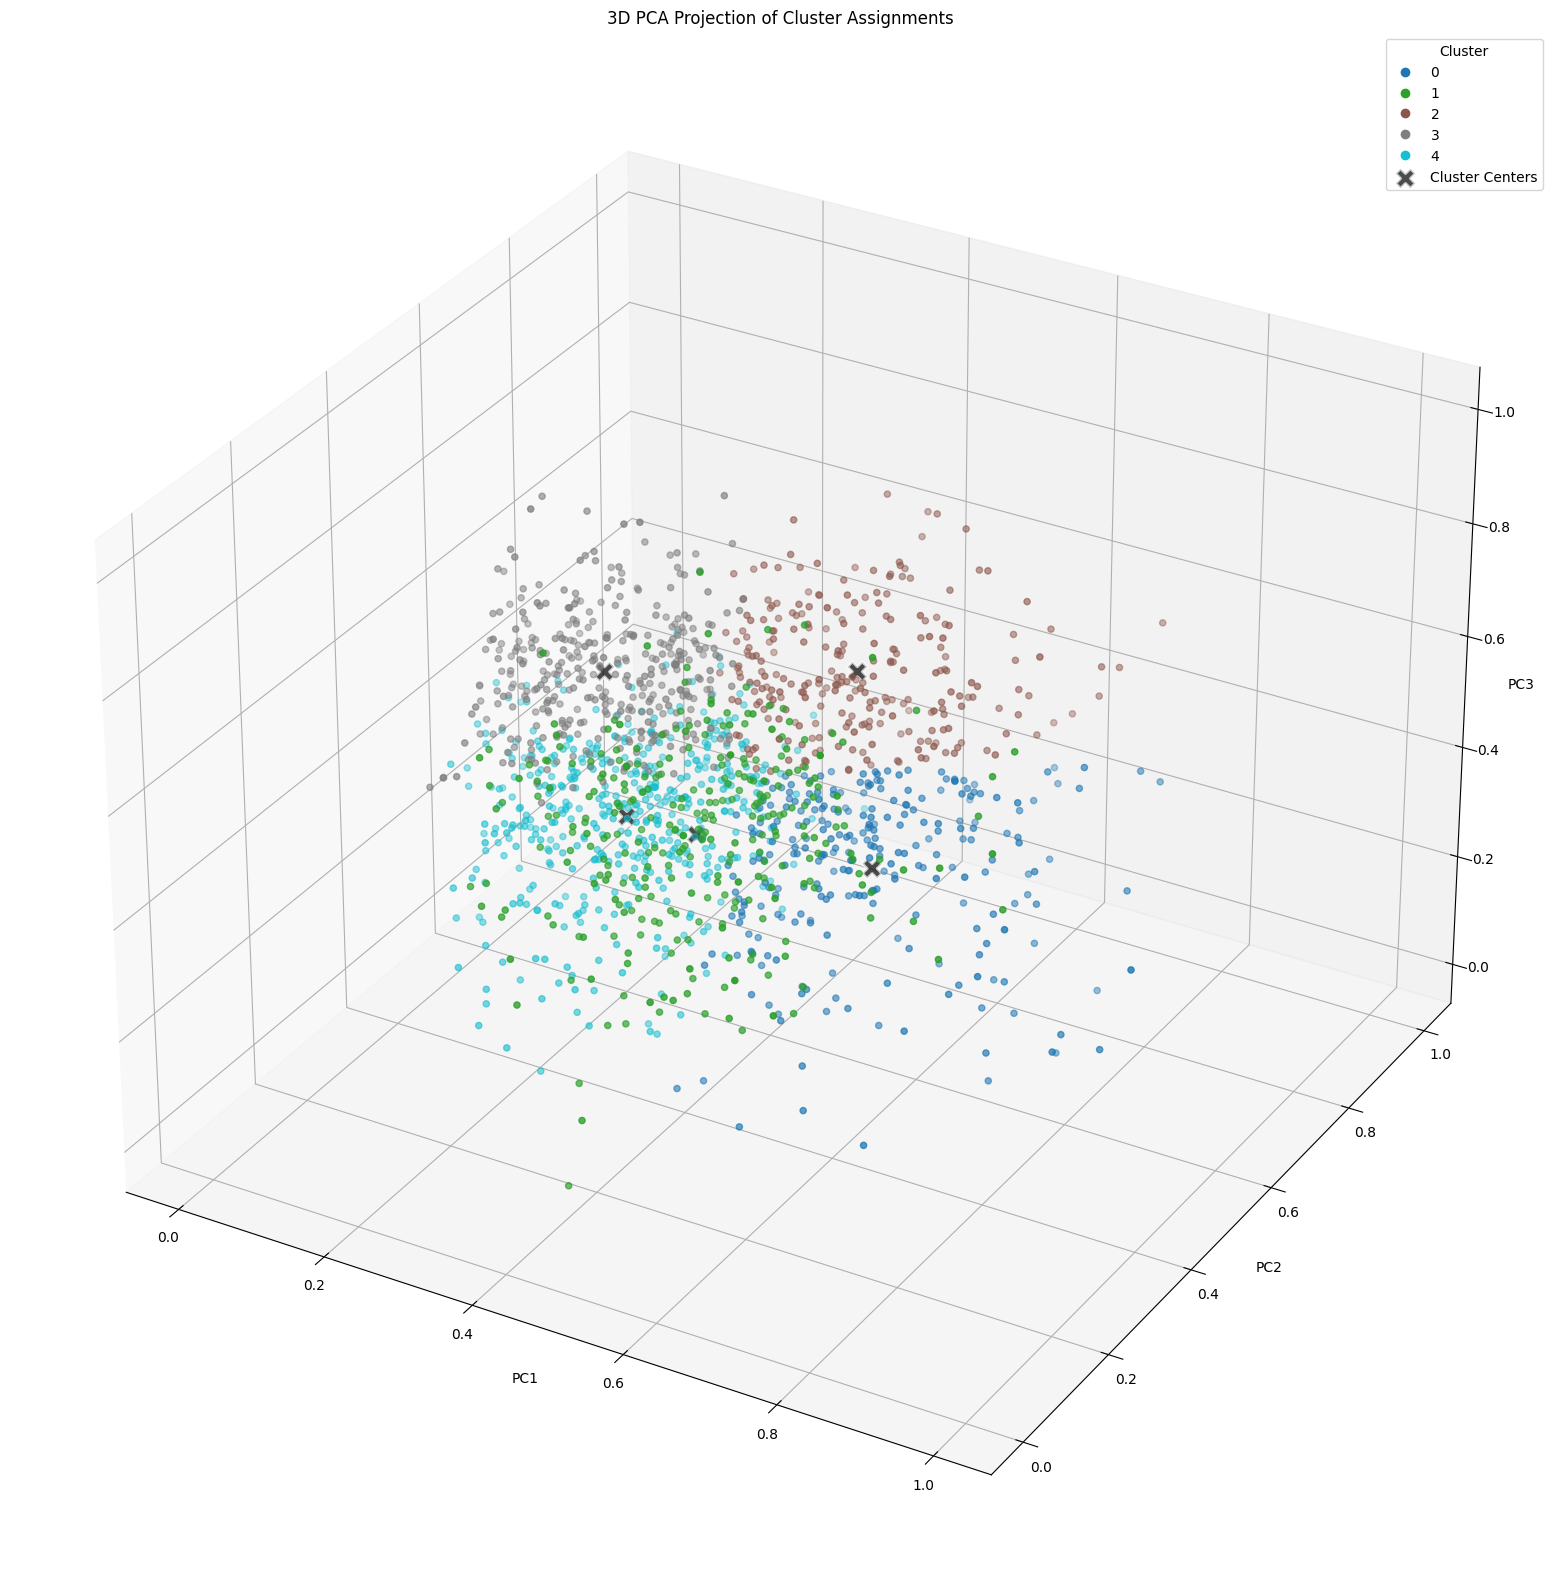

In [85]:
# Plot a 3D scatter plot
plot_feature_scatter(output, clusters=5, n_components=3)